 ----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<h1><center>
    
Practical exam on Computer Vision: Part II
    
(January, 18th, 2024)
</center></h1>   

Consider the following:

- You can answer in English, Spanish or Catalan. 

- Add title to figures and add sufficient comments on the code to understand it.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- At the end of the exam, upload only your .ipynb file (no need to upload the images)
    
- Make sure your code can be ran by us without errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please note that partial credit will be given based on the correctness of the code and the logic demonstrated. If certain parts of your code or answers are accurate, even if the final output is not entirely correct, you may still receive points.

----------------------------------------------------------------------------------------------------

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, img_as_ubyte, img_as_float
from skimage.io import imsave, imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import hog
import matplotlib.patches as patches
from skimage.color import rgb2gray,rgba2rgb
from sklearn.model_selection import train_test_split
from skimage.transform import integral_image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

In [21]:
def visualize_image_group(images, titles):
    """
    Given a list of images and its corresponding titles,
    shows all the images in a plot with each title above.
    """

    f, axarr = plt.subplots(1, len(images))
    f.set_size_inches(12, 12)

    for i in range(len(images)):
        if images[i].ndim == 2:
            axarr[i].imshow(images[i], cmap='gray')
        else:
            axarr[i].text(0.5, 0.5, str(images[i]), ha='center', va='center')

        axarr[i].set_title(titles[i])
        axarr[i].axis('off')

    plt.tight_layout()
    plt.show()


## Exercise 1

### Improving the HOG detection

A collaboration has been initiated between several departments at the University of Barcelona and a big company. As part of the collaboration, an exercise has been assigned to assess potential new team members. This exercise is a modified version of one covered in class. 

In the earlier task, we examined the effectiveness of the HOG descriptor in person detection by employing a uniform template across various images. Now, we aim to deepen its understanding by comparing the impact of using different templates.

**Ex.1.1** (1 points) Load the images `silhouette_cropped.png`, `person_template1.bmp` and `person_template2.png` from the folder `images`. Obtain their HOG descriptors and visualize them. Use the default parameters of the HOG function. All the images should be transformed to grayscale. Take as an example the following image:

<img src="images/exercise11_1.png" width="315" height="350"><img src="images/exercise11_2.png" width="315" height="350"><img src="images/exercise11_3.png" width="315" height="350">

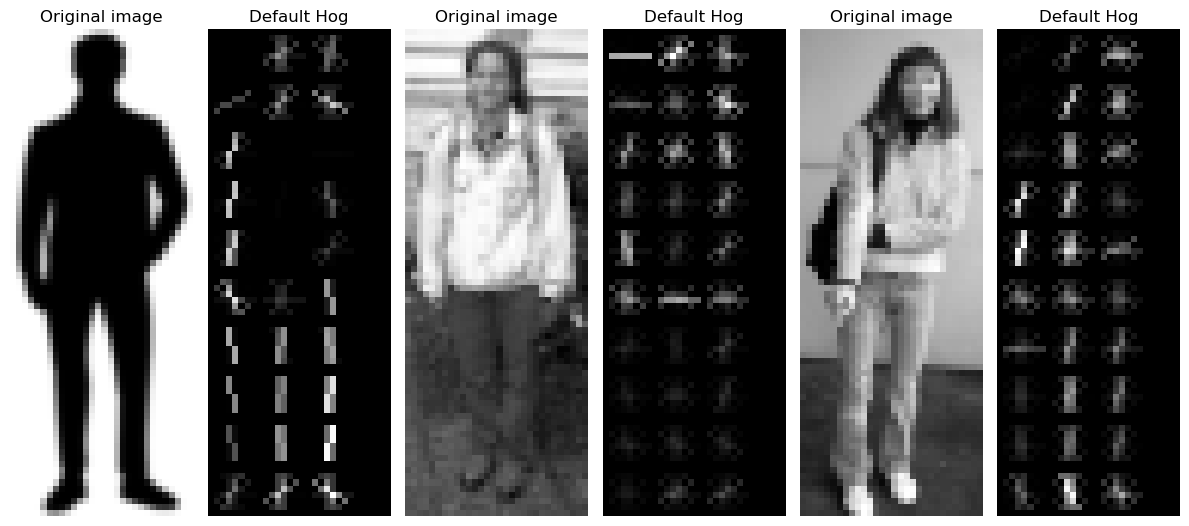

In [36]:
# Your solution
template1=io.imread("images/template1.png")
template2=io.imread("images/template2.bmp")
template3=io.imread("images/template3.png")

template1_gray_float = img_as_float(template1)
template2_gray_float = img_as_float(template2)
template3_gray_float = img_as_float(template3)

def get_HOG(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=True):
    """
    Function that returns the HOG of a given image.
    """
    # Convertir la imagen a formato RGB si es RGBA
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    
    # Convertir la imagen a escala de grises si es RGB
    if image.shape[-1] == 3:
        image = rgb2gray(image)
    
    # Convertir la imagen a escala de grises y formato float
    image_gray = img_as_float(image)
    
    # Obtener el HOG de la imagen anterior.
    _, hog_image = hog(image_gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=visualize)
    
    return hog_image


# Get HOG descriptor with default parameters
hog_default_image1 = get_HOG(template1_gray_float, visualize=True)
hog_default_image2 = get_HOG(template2_gray_float, visualize=True)
hog_default_image3 = get_HOG(template3_gray_float, visualize=True)

# Visualize the results for each rotation angle
images_result = [template1_gray_float, hog_default_image1, template2_gray_float, hog_default_image2, template3_gray_float, hog_default_image3, ]
titles_result = ['Original image', 'Default Hog','Original image', 'Default Hog','Original image', 'Default Hog']
    
# Visualize the images for each rotation angle
visualize_image_group(images_result, titles_result)


**Ex.1.2** (2 points) Apply the previous templates to the image: `images/TestPersonImages/person_027.bmp`. Read the image and slide a window on each template to store the most similar Region of Interest, using Norm 2 (np.linalg.norm). Visualize the images in a 1x3 grid of images, like in the example below. All the images have been resized to accelerate the computation.

*Hint*: This exercise could take up a few seconds running, however it should not take minutes.
<img src="images/exercise12.png" width="515" height="350">

In [28]:
def compare_hog(template, image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
    """
    Compara un template con una image mediante HOG.
    :param template: Template que queremos utilizar.
    :param image: Imagen para encontrar el template con HOG.
    :param orientations: Número de orientaciones para el descriptor HOG.
    :param pixels_per_cell: Tamaño de los píxeles en cada celda.
    :param cells_per_block: Tamaño de los bloques en celdas.
    """
    # Generate the HOG of the template
    hog_template = get_HOG(template, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)

    dimensions = [image.shape[i] - template.shape[i] for i in range(2)]
    
    # Create a black image to put the HOG with the size of the original image
    result = np.ones([image.shape[0], image.shape[1]])
    
    data = []
    
    # Slicing with x of 5
    for i in range(0, dimensions[0], 5):
        for j in range(0, dimensions[1], 5):
            
            # Center for the result HOG to display
            posx = template.shape[0] + i - (int(template.shape[0] / 2))
            posy = template.shape[1] + j - (int(template.shape[1] / 2))
            
            # Get the region of the image to generate the HOG
            region = image[i:i+template.shape[0], j:j+template.shape[1]]
            hog_region_rescaled = get_HOG(region, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
            
            # Do euclidean distance with HOG of our region and our template
            hog_distance = np.linalg.norm(hog_region_rescaled - hog_template)
            result[posx, posy] = hog_distance
            
            # Save the information into the PriorityQueue
            data += [[hog_distance, [i, j]]]
        
    minims = [min(data)[1][1], min(data)[1][0]]
    
    # Generate two rectangles for the HOG and the original image
    rect = patches.Rectangle(minims, template.shape[1], template.shape[0], edgecolor='r', facecolor='none')

    return [template, image, result, rect]


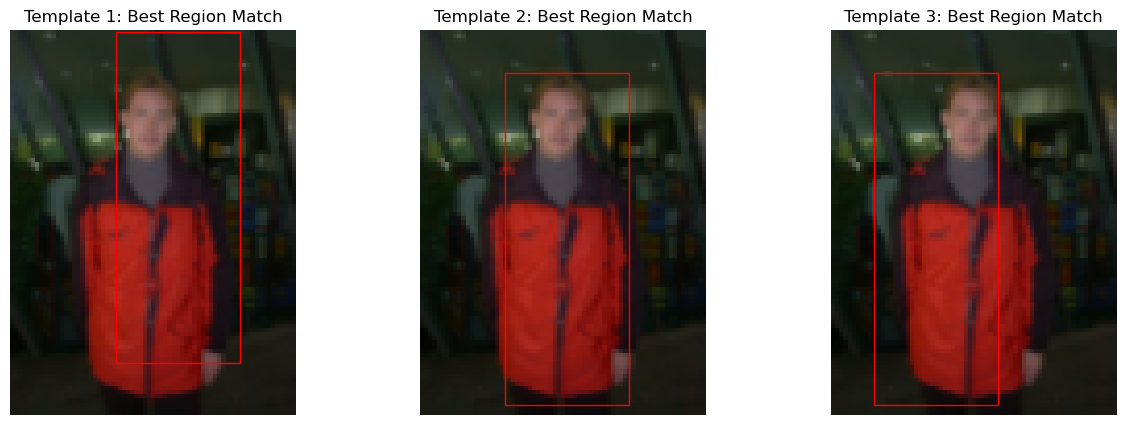

In [38]:
# Your solution
test_image = io.imread("images/TestPersonImages/person_025.bmp")

templates = [template1_gray_float, template2_gray_float, template3_gray_float]
template_names = ["Template 1", "Template 2", "Template 3"]  # Nombres de los templates

# Comparar cada template con la imagen de prueba
fig, ax = plt.subplots(1, len(templates), figsize=(15, 5))

for i, (template, name) in enumerate(zip(templates, template_names)):
    result = compare_hog(template, test_image)

    # Display the original image with rectangle indicating best match
    ax[i].imshow(result[1], cmap=plt.cm.gray)
    ax[i].set_title(f'{name}: Best Region Match')
    ax[i].add_patch(result[3])  # Rectangle for the HOG
    ax[i].axis('off')

plt.show()

Which template has been the best choice for the detection task?

<font color="blue">La mejor plantilla para la tarea de detección a sido el "template2"

The images are smaller in size than the ones used in class. Has this influenced the results?

<font color="blue">Sí, el tamaño reducido de las imágenes lleva a que haya menos detalles, lo que significa que los descriptores HOG pueden capturar menos características distintivas. Al reducirse la imagen, se pueden perder texturas que son cruciales para la identificación precisa mediante HOG.

## Exercise 2

### Autonomous cars

A big car company has started a proyect to create autonomous cars. The autonomous car market is quite advanced, and they are working around the clock to catch up with their competitors and establish themselves as a leading brand in autonomous electric vehicles by 2026. The goal is to recognize different vehicles on the road to react to unforeseen events. Considering your performance in the previous task, you are now a member of this team.

**Ex 2.1** (2 points) Read the images from the directories `./images/vehicles/bike`, `./images/vehicles/boat`, `./images/vehicles/bus`, `./images/vehicles/car`, `./images/vehicles/cycle`. Transform the RGB images to grayscale and resize them to 100x100 pixels (to reduce computation time). Build two arrays: one, X, with all the features, and the other, y, containing the label of the images. The class_labels for the images should be: 0 = bike, 1 = boat, 2 = bus, 3 = car, 4 = cycle.

To check the correctness of the exercise, visualize the images number 0, 150 and 300, along with their type. The next image is an example of the result:

<img src="images/exercise21.png" width="515" height="350">

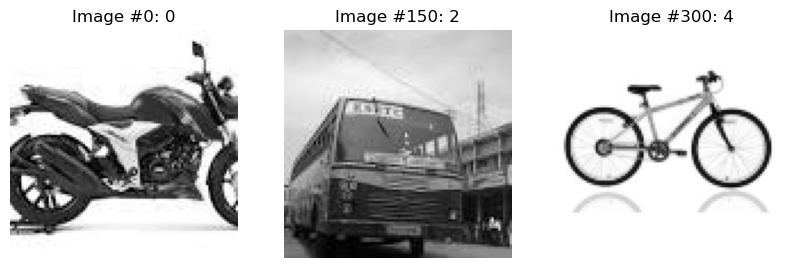

In [5]:
# Your solution
def read_and_resize_images(directory, target_size=(100, 100)):
    images = []
    for image_name in os.listdir(directory):
        # Lee la imagen
        image_path = os.path.join(directory, image_name)
        image = io.imread(image_path)

        # Verifica si la imagen es RGBA y la convierte a RGB
        if image.shape[-1] == 4:
            image = rgba2rgb(image)

        # Redimensiona la imagen
        resized_image = resize(image, target_size, anti_aliasing=True)

        # Verifica si la imagen es RGB y la convierte a escala de grises si es necesario
        if len(resized_image.shape) == 3:
            gray_image = rgb2gray(resized_image)
        else:
            gray_image = resized_image

        # Aplana la imagen y la añade a la lista de imágenes
        images.append(gray_image.flatten())
    return images
        
bike_images = read_and_resize_images("images/vehicles/bike/")
boat_images =read_and_resize_images("images/vehicles/boat/")
bus_images = read_and_resize_images("images/vehicles/bus/")
car_images =read_and_resize_images("images/vehicles/car/")
cycle_images = read_and_resize_images("images/vehicles/cycle/")

# Diccionario para asignar etiquetas a las clases
class_labels = {'bike': 0, 'boat': 1, 'bus': 2, 'car': 3, 'cycle': 4}

# Listas para características y etiquetas
X = []
y = []

# Carga las imágenes de cada clase y les asigna una etiqueta
for class_name, label in class_labels.items():
    images = read_and_resize_images(f'./images/vehicles/{class_name}')
    X.extend(images)
    y.extend([label] * len(images))

# Convierte las listas a arrays de NumPy
X = np.array(X)
y = np.array(y)


# Función para visualizar imágenes
def visualize_images(X, y, indices, class_labels):
    fig, axes = plt.subplots(1, len(indices), figsize=(10, 5))
    for ax, idx in zip(axes, indices):
        ax.imshow(X[idx].reshape(100, 100), cmap='gray')
        ax.set_title(f'Image #{idx}: {y[idx]}')

        ax.axis('off')
    plt.show()

# Visualiza las imágenes en los índices 0, 150 y 300
indices_to_visualize = [0, 150, 300]
visualize_images(X, y, indices_to_visualize, class_labels)


**Ex 2.2** (1,5 points) Divide the dataset into train set and test set, the test set size being the 30% of the total dataset. Create a PCA object of 30 components and visualize 20 principal components.
​
The next image is an example of the result:
​
<img src="images/exercise32.png" width="515" height="350">

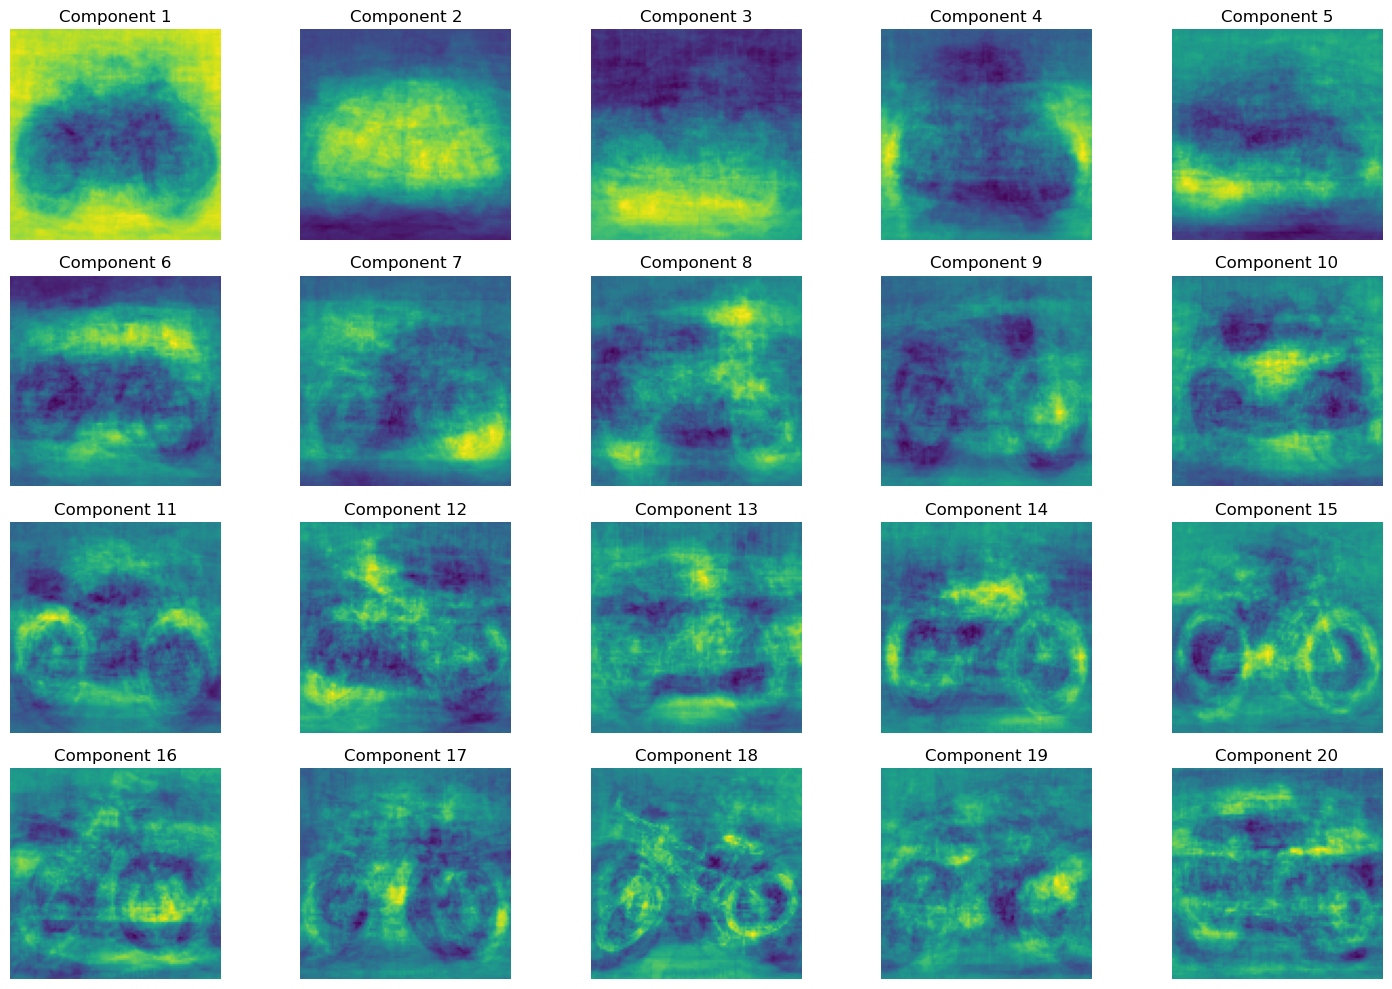

In [7]:
# Your solution
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Crear un objeto PCA con 30 componentes principales
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)

# Visualizar las primeras 20 componentes principales
fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # Crear una cuadrícula 4x5 para 20 componentes
for i, ax in enumerate(axes.flat[:20]):  # Iterar sobre las primeras 20 componentes
    component_image = pca.components_[i].reshape(100, 100)  # Reshape para mostrar como una imagen
    ax.imshow(component_image, cmap='viridis')
    ax.set_title(f'Component {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Exercise 3

### Introducing the AdaBoost

The perfomance in the previous exercise has been better than expected. The board of inverstors is happy with your achievements and have moved the release date of the new software from 2026 to 2025. That means there is more work to do: you now need to create an algorithm able to classify a larger volume of images. Currently, you will continue using the same set of images as in the previous exercise.

**Ex 3.1** (2 points) Use the images from the previous directories `./images/vehicles/bike`, `./images/vehicles/boat`, `./images/vehicles/bus`, `./images/vehicles/car`, `./images/vehicles/cycle`. Resize them to 15x15 pixels (to reduce computation time even more). Build an array X, using the built `extract_feature_image` method seen in P5, with all the given Haar-like features (which are usually used for faces).
                 
Print the shape of both arrays. The shape of X should be (305, 78460), and the shape of y (305,).

```python
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']
```

*Hint*: This exercise could take up a few seconds running, however it should not take minutes.

In [37]:
import numpy as np
from skimage.feature import haar_like_feature, haar_like_feature_coord
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.io import imread
import os

# Función para extraer características Haar-like de una imagen
def extract_feature_image(image, feature_types):
    # Convertir la imagen a escala de grises si es necesario
    if len(image.shape) == 3:
        image = rgb2gray(image)
    
    # Extraer características Haar-like
    haar_features = haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], feature_type=feature_types)
    return haar_features

# Función para procesar directorios de imágenes y extraer características Haar-like
def process_images(directory, label, feature_types, target_size=(15, 15)):
    X = []
    y = []
    
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = imread(image_path)
        
        # Redimensionar la imagen
        resized_image = resize(image, target_size, anti_aliasing=True)
        
        # Extraer características Haar-like
        features = extract_feature_image(resized_image, feature_types)
        
        X.append(features)
        y.append(label)
    
    return np.array(X), np.array(y)

# Tipos de características Haar-like
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']

# Directorios y etiquetas
directories = {
    "bike": 0,
    "boat": 1,
    "bus": 2,
    "car": 3,
    "cycle": 4
}

# Inicializar matrices X (características) y y (etiquetas)
X = []
y = []

# Procesar cada directorio
for class_name, label in directories.items():
    dir_path = f"./images/vehicles/{class_name}"
    X_class, y_class = process_images(dir_path, label, feature_types)
    X.extend(X_class)
    y.extend(y_class)

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

# Imprimir las formas de las matrices X e y
print(f"Shape of X: {X.shape}")  # Debería ser (305, 78460)
print(f"Shape of y: {y.shape}")  # Debería ser (305,)


Shape of X: (305, 24976)
Shape of y: (305,)


**Ex 3.2** (1,5 points) Train an Adaboost classifier with 10 estimators. Use the *predict* and *score* methods of the classifier to evaluate the testing accuracy *(percentage of correctly classified images)*. The test size must be the 30% (i.e. 0.3) of the whole dataset. Use the ``train_test_split()`` function from `sklearn.model_selection`. The labels used in this function should be the same as in the previous exercise.

In [39]:
# Your solution
import numpy as np
from skimage.feature import haar_like_feature, haar_like_feature_coord
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.io import imread
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Función para extraer características Haar-like de una imagen
def extract_feature_image(image, feature_types):
    # Convertir la imagen a escala de grises si es necesario
    if len(image.shape) == 3:
        image = rgb2gray(image)
    
    # Extraer características Haar-like
    haar_features = haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], feature_type=feature_types)
    return haar_features

# Función para procesar directorios de imágenes y extraer características Haar-like
def process_images(directory, label, feature_types, target_size=(15, 15)):
    X = []
    y = []
    
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = imread(image_path)
        
        # Redimensionar la imagen
        resized_image = resize(image, target_size, anti_aliasing=True)
        
        # Extraer características Haar-like
        features = extract_feature_image(resized_image, feature_types)
        
        X.append(features)
        y.append(label)
    
    return np.array(X), np.array(y)

# Tipos de características Haar-like
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']

# Directorios y etiquetas
directories = {
    "bike": 0,
    "boat": 1,
    "bus": 2,
    "car": 3,
    "cycle": 4
}

# Inicializar matrices X (características) y y (etiquetas)
X = []
y = []

# Procesar cada directorio
for class_name, label in directories.items():
    dir_path = f"./images/vehicles/{class_name}"
    X_class, y_class = process_images(dir_path, label, feature_types)
    X.extend(X_class)
    y.extend(y_class)

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

# Imprimir las formas de las matrices X e y
print(f"Shape of X: {X.shape}")  # Debería ser (305, algo)
print(f"Shape of y: {y.shape}")  # Debería ser (305,)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar PCA para reducir a 15 componentes principales
n_components = 15
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Entrenar el clasificador AdaBoost con 10 estimadores
adaboost_model = AdaBoostClassifier(n_estimators=10, random_state=42)
adaboost_model.fit(X_train_pca, y_train)

# Evaluar el modelo en el conjunto de prueba
test_accuracy = adaboost_model.score(X_test_pca, y_test) * 100
print(f"Testing accuracy: {test_accuracy:.2f}%")

# Evaluar el modelo en el conjunto de entrenamiento
train_accuracy = adaboost_model.score(X_train_pca, y_train) * 100
print(f"Training accuracy: {train_accuracy:.2f}%")

Shape of X: (305, 24976)
Shape of y: (305,)
Testing accuracy: 25.00%
Training accuracy: 47.42%


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
